In [7]:
import matplotlib.pyplot as plt
from skimage import data, color, feature
import skimage.data

Text(0.5, 1.0, 'hog features')

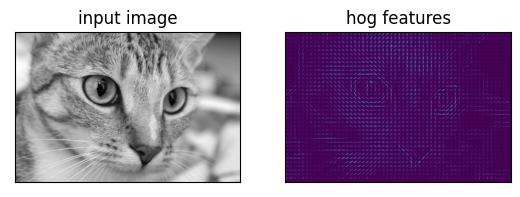

In [8]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)
fig, ax = plt.subplots(1, 2, subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')
ax[1].imshow(hog_vis)
ax[1].set_title('hog features')

In [9]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [10]:
data.camera().shape

(512, 512)

In [15]:
from skimage import data, transform
import numpy as np

In [12]:
imgs = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
raw = (getattr(data, name)() for name in imgs)
images = [color.rgb2gray(image) if image.ndim == 3 else image for image in raw]

In [13]:
from sklearn.feature_extraction.image import PatchExtractor

In [16]:
def extract_patches(img, N, scale=1, patch_size=positive_patches[0].shape):
  extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
  extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
  patches = extractor.transform(img[np.newaxis])

  if scale != 1:
    patches = np.array([transform.resize(patch, patch_size) for patch in patches])
  
  return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [.5, 1, 2]])
negative_patches.shape


(30000, 62, 47)

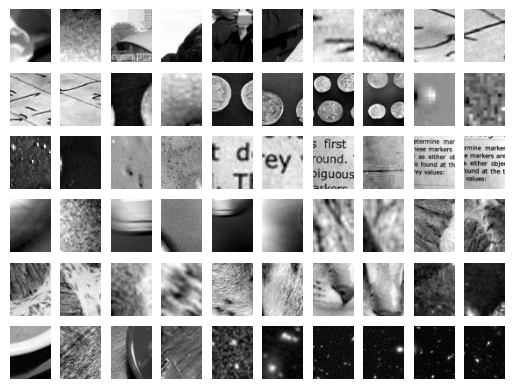

In [17]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
  axi.imshow(negative_patches[500 * i], cmap='gray')
  axi.axis('off')

In [18]:
from itertools import chain

In [21]:
X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape

(43233, 1215)

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [23]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.95663236, 0.972476  , 0.97363247, 0.97640527, 0.97536433])

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [27]:
grid = GridSearchCV(LinearSVC(), {'C': [1, 2, 4, 8]})
grid.fit(X_train, y_train)
grid.best_score_

/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

0.9887817015824171

In [28]:
grid.best_params_

{'C': 2}

In [29]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2)

(-0.5, 139.5, 159.5, -0.5)

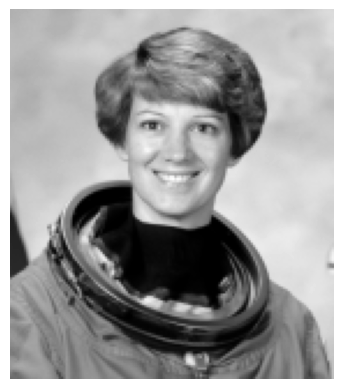

In [30]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, .5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')


In [33]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1):
  Ni, Nj = (int(scale*s) for s in patch_size)
  for i in range(0, img.shape[0] - Ni, istep):
    for j in range(0, img.shape[1] - Ni, jstep):
      patch = img[i:i + Ni, j:j + Nj]
      if scale != 1:
        patch = transform.resize(patch, patch_size)
      yield (i, j), patch

In [34]:
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [35]:
labels = model.predict(patches_hog)
labels.sum()

46.0

In [36]:
labels

array([0., 0., 0., ..., 0., 0., 0.])

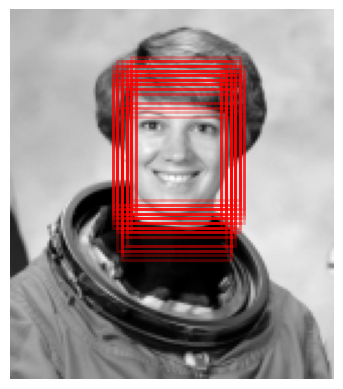

In [38]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj, = positive_patches[0].shape
indicies = np.array(indices)

for i, j in indicies[labels == 1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=.3, lw=2, facecolor='none'))